In [1]:
import os
import pickle
import gridfs
import pymongo
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,precision_score,recall_score,f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.ensemble import BaggingClassifier
from warnings import filterwarnings
filterwarnings("ignore")

In [2]:
RAND_STATE=42
DB='ML_diabetes'
DBCONNECTION='models'
CLIENT='mongodb://localhost:27017/'
MODEL_NAME = 'diabetes'

# part 1 - load and explore the data

In [3]:
df=pd.read_csv("diabetes_binary_5050split_health_indicators_BRFSS2015.csv")

In [4]:
df

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70687,1.0,0.0,1.0,1.0,37.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,0.0,0.0,6.0,4.0,1.0
70688,1.0,0.0,1.0,1.0,29.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,2.0,0.0,0.0,1.0,1.0,10.0,3.0,6.0
70689,1.0,1.0,1.0,1.0,25.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,5.0,15.0,0.0,1.0,0.0,13.0,6.0,4.0
70690,1.0,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,1.0,0.0,11.0,2.0,4.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Diabetes_binary       70692 non-null  float64
 1   HighBP                70692 non-null  float64
 2   HighChol              70692 non-null  float64
 3   CholCheck             70692 non-null  float64
 4   BMI                   70692 non-null  float64
 5   Smoker                70692 non-null  float64
 6   Stroke                70692 non-null  float64
 7   HeartDiseaseorAttack  70692 non-null  float64
 8   PhysActivity          70692 non-null  float64
 9   Fruits                70692 non-null  float64
 10  Veggies               70692 non-null  float64
 11  HvyAlcoholConsump     70692 non-null  float64
 12  AnyHealthcare         70692 non-null  float64
 13  NoDocbcCost           70692 non-null  float64
 14  GenHlth               70692 non-null  float64
 15  MentHlth           

as we can see all the columns are floats, no need to encode anything.

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Diabetes_binary,70692.0,0.500000,0.500004,0.0,0.0,0.5,1.0,1.0
HighBP,70692.0,0.563458,0.495960,0.0,0.0,1.0,1.0,1.0
HighChol,70692.0,0.525703,0.499342,0.0,0.0,1.0,1.0,1.0
CholCheck,70692.0,0.975259,0.155336,0.0,1.0,1.0,1.0,1.0
BMI,70692.0,29.856985,7.113954,12.0,25.0,29.0,33.0,98.0
Smoker,70692.0,0.475273,0.499392,0.0,0.0,0.0,1.0,1.0
Stroke,70692.0,0.062171,0.241468,0.0,0.0,0.0,0.0,1.0
HeartDiseaseorAttack,70692.0,0.147810,0.354914,0.0,0.0,0.0,0.0,1.0
PhysActivity,70692.0,0.703036,0.456924,0.0,0.0,1.0,1.0,1.0
Fruits,70692.0,0.611795,0.487345,0.0,0.0,1.0,1.0,1.0


we can see some interesting information, such as that ages ranging from 1 to 13, more then 50% has high choleresterol, around 50% has diabetes.

In [7]:
df.isna().sum()

Diabetes_binary         0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64

no nulls is this data set

In [8]:
for col in df:
    print("unique in {}:".format(col),df[col].unique())
    # print(df[col].unique())

unique in Diabetes_binary: [0. 1.]
unique in HighBP: [1. 0.]
unique in HighChol: [0. 1.]
unique in CholCheck: [1. 0.]
unique in BMI: [26. 28. 29. 18. 31. 32. 27. 24. 21. 58. 30. 20. 22. 38. 40. 25. 36. 47.
 19. 37. 41. 23. 34. 35. 42. 17. 33. 44. 15. 52. 69. 56. 45. 39. 92. 53.
 98. 50. 46. 79. 48. 16. 63. 72. 54. 49. 68. 43. 84. 73. 76. 55. 51. 75.
 57. 60. 12. 77. 82. 67. 71. 61. 14. 81. 59. 86. 13. 87. 65. 95. 89. 62.
 64. 66. 85. 70. 83. 80. 78. 74.]
unique in Smoker: [0. 1.]
unique in Stroke: [0. 1.]
unique in HeartDiseaseorAttack: [0. 1.]
unique in PhysActivity: [1. 0.]
unique in Fruits: [0. 1.]
unique in Veggies: [1. 0.]
unique in HvyAlcoholConsump: [0. 1.]
unique in AnyHealthcare: [1. 0.]
unique in NoDocbcCost: [0. 1.]
unique in GenHlth: [3. 1. 2. 4. 5.]
unique in MentHlth: [ 5.  0.  7.  3.  4.  2. 30. 20.  1. 15. 10. 25. 14. 28.  6. 29. 26. 12.
 16. 22. 13.  8.  9. 21. 18. 17. 27. 24. 23. 11. 19.]
unique in PhysHlth: [30.  0. 10.  3.  6.  4. 15.  1.  2. 14.  7. 25. 21. 20.  5.

# part 2 - data visualization

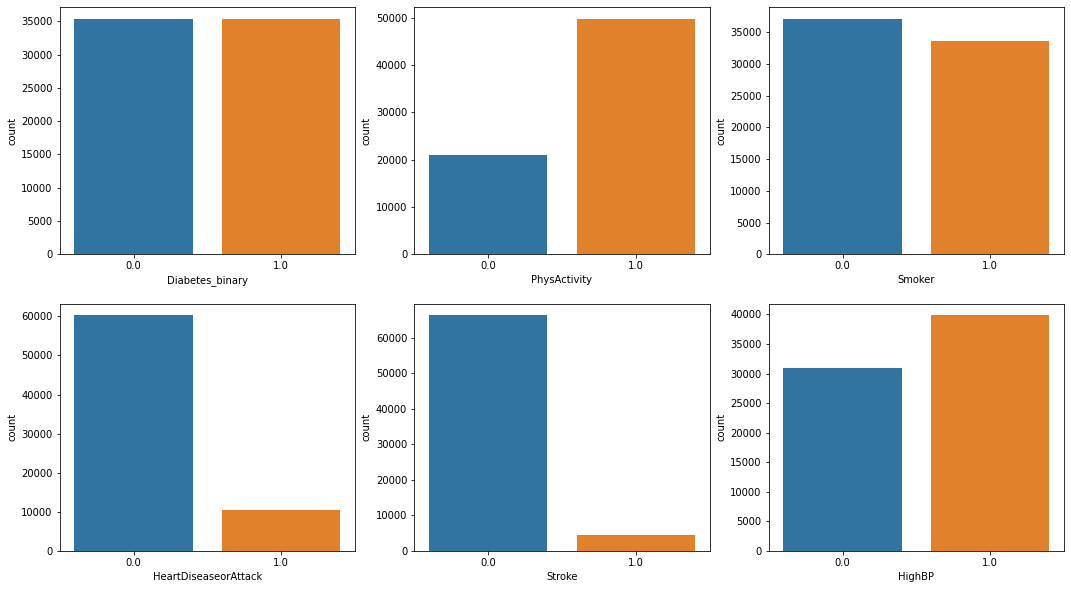

In [9]:
plt.figure(figsize=(18,10))
for i,col in enumerate(["Diabetes_binary","PhysActivity","Smoker","HeartDiseaseorAttack","Stroke","HighBP"],start=1):
    plt.subplot(2,3,i)
    sns.countplot(df[col]);

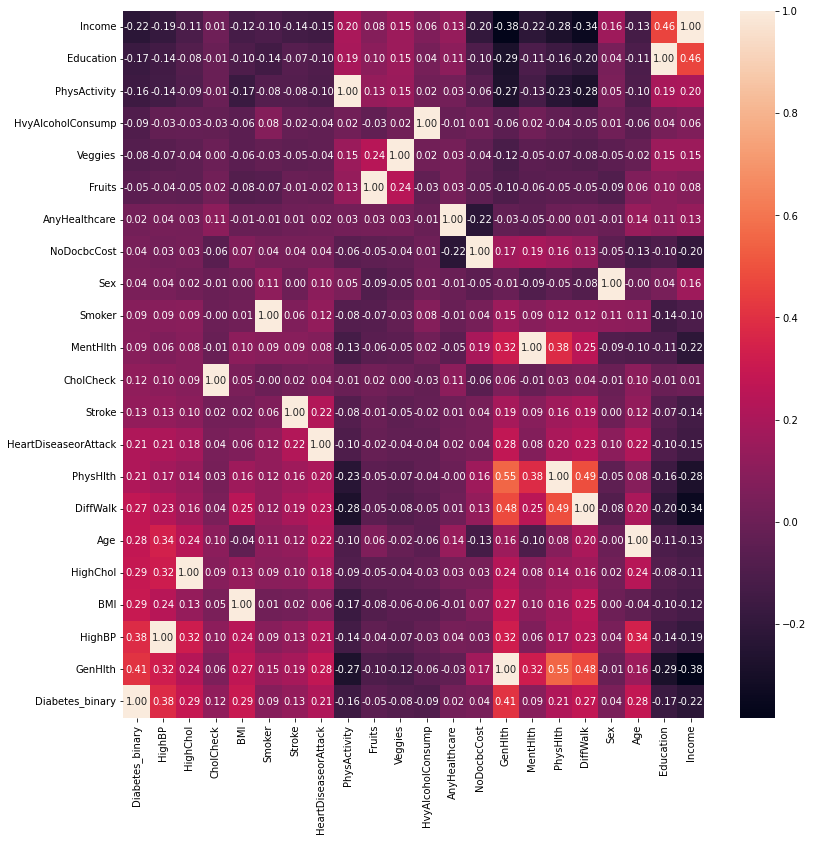

In [10]:
plt.figure(figsize=(13,13))
sns.heatmap(df.corr().sort_values(by="Diabetes_binary"),annot=True,fmt=".2f");

by our sorted heatmap the middle has the lowest corraletion so we can drop them.<br>
we will drop AnyHealthcare,NoDocbcCost,Sex,Smoker,MentHlth,HvyAlcoholConsump,Veggies,Fruits

In [11]:
df.drop(["AnyHealthcare","NoDocbcCost","Sex","Smoker","MentHlth","HvyAlcoholConsump","Veggies","Fruits"],axis=1,inplace=True)
df

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Stroke,HeartDiseaseorAttack,PhysActivity,GenHlth,PhysHlth,DiffWalk,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,3.0,30.0,0.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,0.0,0.0,3.0,0.0,0.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,1.0,1.0,10.0,0.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,0.0,0.0,1.0,3.0,3.0,0.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,0.0,0.0,1.0,2.0,0.0,0.0,8.0,5.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70687,1.0,0.0,1.0,1.0,37.0,0.0,0.0,0.0,4.0,0.0,0.0,6.0,4.0,1.0
70688,1.0,0.0,1.0,1.0,29.0,0.0,1.0,0.0,2.0,0.0,1.0,10.0,3.0,6.0
70689,1.0,1.0,1.0,1.0,25.0,0.0,1.0,0.0,5.0,0.0,1.0,13.0,6.0,4.0
70690,1.0,1.0,1.0,1.0,18.0,0.0,0.0,0.0,4.0,0.0,1.0,11.0,2.0,4.0


<Figure size 975x975 with 0 Axes>

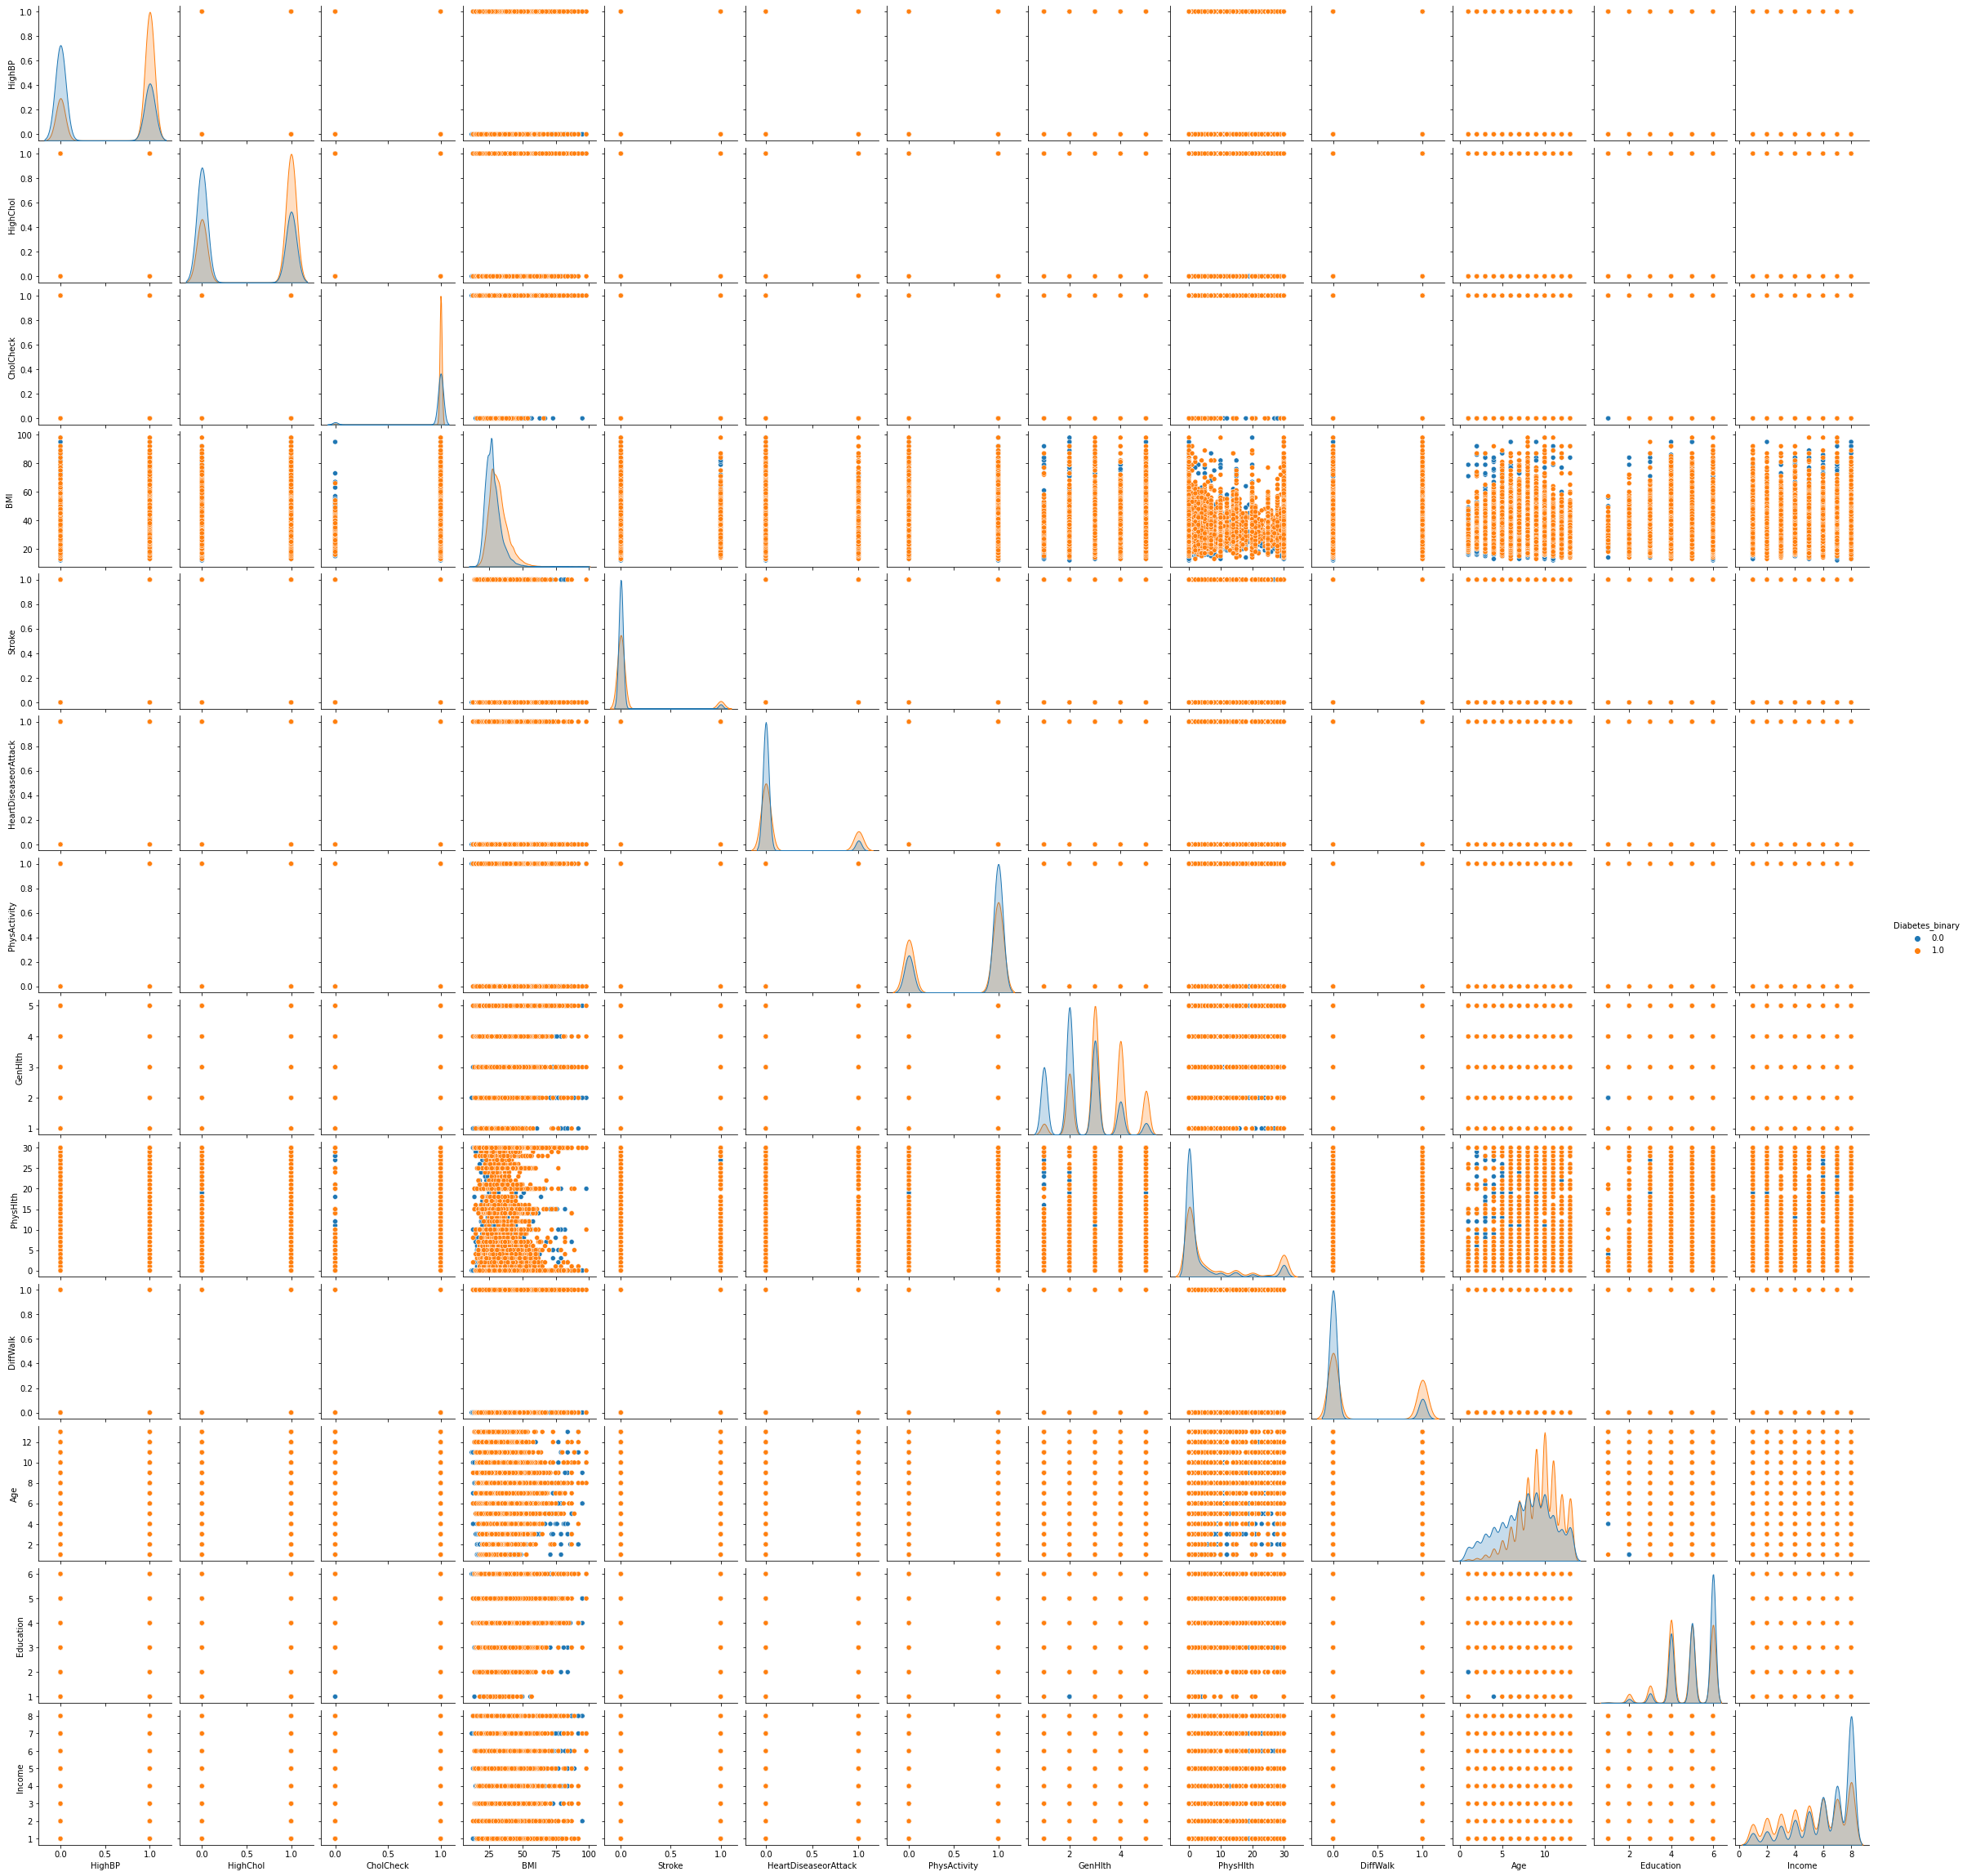

In [13]:
plt.figure(figsize=(13,13),dpi=75)
sns.pairplot(data=df,hue="Diabetes_binary");

# part 3 - looking for outliers and data cleanup

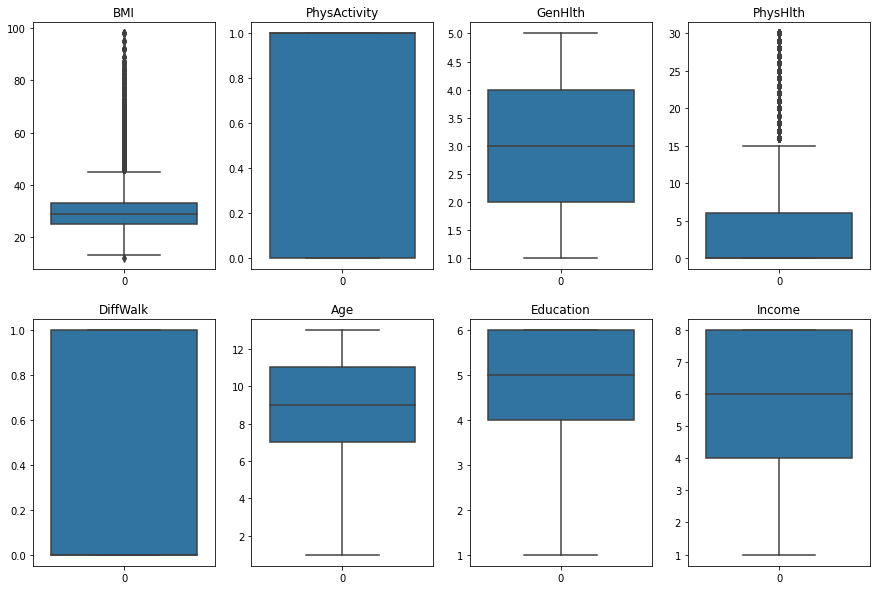

In [14]:
plt.figure(figsize=(15,10))
for i,col in enumerate(['BMI','PhysActivity', 'GenHlth', 'PhysHlth','DiffWalk','Age','Education','Income'],start=1):
       plt.subplot(2,4,i)
       plt.title(col)
       sns.boxplot(data=df[col])

as we can see only BMI and PhysHlth has outliers

In [15]:
q1=df[["BMI","PhysHlth"]].quantile(0.25)
q3=df[["BMI","PhysHlth"]].quantile(0.75)
iqr=q3-q1
lowerBound=q1-iqr*1.5
upperBound=q3+iqr*1.5
df=df[((df[["BMI","PhysHlth"]] > lowerBound) & (df[["BMI","PhysHlth"]] < upperBound)).all(axis=1)]

In [16]:
df.shape

(56585, 14)

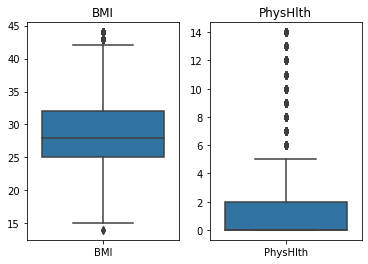

In [17]:
plt.subplot(1,2,1)
plt.title("BMI")
sns.boxplot(data=df[["BMI"]])
plt.subplot(1,2,2)
plt.title("PhysHlth")
sns.boxplot(data=df[["PhysHlth"]]);


# part 4 - creating the models

In [18]:
X=df.drop("Diabetes_binary",axis=1)
X

,HighBP,HighChol,CholCheck,BMI,Stroke,HeartDiseaseorAttack,PhysActivity,GenHlth,PhysHlth,DiffWalk,Age,Education,Income
1,1.0,1.0,1.0,26.0,1.0,0.0,0.0,3.0,0.0,0.0,12.0,6.0,8.0
2,0.0,0.0,1.0,26.0,0.0,0.0,1.0,1.0,10.0,0.0,13.0,6.0,8.0
3,1.0,1.0,1.0,28.0,0.0,0.0,1.0,3.0,3.0,0.0,11.0,6.0,8.0
4,0.0,0.0,1.0,29.0,0.0,0.0,1.0,2.0,0.0,0.0,8.0,5.0,8.0
5,0.0,0.0,1.0,18.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,4.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70687,0.0,1.0,1.0,37.0,0.0,0.0,0.0,4.0,0.0,0.0,6.0,4.0,1.0
70688,0.0,1.0,1.0,29.0,0.0,1.0,0.0,2.0,0.0,1.0,10.0,3.0,6.0
70689,1.0,1.0,1.0,25.0,0.0,1.0,0.0,5.0,0.0,1.0,13.0,6.0,4.0
70690,1.0,1.0,1.0,18.0,0.0,0.0,0.0,4.0,0.0,1.0,11.0,2.0,4.0


In [19]:
y=df["Diabetes_binary"]
y

1        0.0
2        0.0
3        0.0
4        0.0
5        0.0
        ... 
70687    1.0
70688    1.0
70689    1.0
70690    1.0
70691    1.0
Name: Diabetes_binary, Length: 56585, dtype: float64

creating the scaler

In [20]:
scaler=MinMaxScaler()
X=scaler.fit_transform(X)
X

array([[1.        , 1.        , 1.        , ..., 0.91666667, 1.        ,
        1.        ],
       [0.        , 0.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 0.83333333, 1.        ,
        1.        ],
       ...,
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        0.42857143],
       [1.        , 1.        , 1.        , ..., 0.83333333, 0.2       ,
        0.42857143],
       [1.        , 1.        , 1.        , ..., 0.66666667, 1.        ,
        0.14285714]])

splitting the data

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RAND_STATE)

In [22]:
print(f"x test size: {X_test.shape}\nx train size: {X_train.shape}")

x test size: (11317, 13)
x train size: (45268, 13)


In [26]:
def searchModel(params,estimator,cv=10,n_iter=10):
    search=RandomizedSearchCV(
        estimator=estimator,
        param_distributions=params,
        n_iter=n_iter,
        cv=cv,
        n_jobs=-1
    )
    search.fit(X_train,y_train)
    print(search.best_params_)
    print(search.best_score_)
    return search.best_estimator_

In [24]:

def searchBagging(estimator,cv=10,n_iter=10,oob_score=[True,False],bootstrap=[True,False],max_features=np.arange(0.5,1,0.1),
                n_estimators=np.arange(100,251,50),max_samples=np.arange(0.6,1,0.1)):

    if isinstance(bootstrap,list):
        params=[{"base_estimator":[estimator],
            "n_estimators":n_estimators,
            "max_samples":max_samples,
            "max_features":max_features,
            "bootstrap":[False],
            "random_state":[RAND_STATE],
            "n_jobs":[-1]
            },
            {"base_estimator":[estimator],
            "n_estimators":n_estimators,
            "max_samples":max_samples,
            "max_features":max_features,
            "oob_score":oob_score,
            "bootstrap":[True],
            "random_state":[RAND_STATE],
            "n_jobs":[-1]
            }]
    else:
        params={"base_estimator":[estimator],
            "n_estimators":n_estimators,
            "max_samples":max_samples,
            "max_features":max_features,
            "oob_score":oob_score,
            "bootstrap":bootstrap,
            "random_state":[RAND_STATE],
            "n_jobs":[-1]
            }
            
    bagGridModel=RandomizedSearchCV(
        estimator=BaggingClassifier(),
        param_distributions=params,
        n_iter=n_iter,
        cv=cv,
        random_state=RAND_STATE,
        n_jobs=-1
    )
    bagGridModel.fit(X_train,y_train)
    print(bagGridModel.best_params_)
    print(bagGridModel.best_score_)
    return bagGridModel.best_estimator_

now let's search the best models.<br>
we will use a function that preforming the grid search for us based on the parameters, model and cv we send to it.

In [27]:
params={
    "KNeighborsClassifier()":{"n_neighbors":np.arange(3,26,2),"p":np.arange(1,9),"algorithm":['auto', 'kd_tree', 'brute']},
    "SVC()":[{"C":np.arange(1,0,-0.1),"kernel":['linear']},
            {"kernel":['poly', 'rbf', 'sigmoid'],"gamma":['scale', 'auto',*list(np.arange(0,1.1,0.1))]}],
    "MultinomialNB()":{"alpha":np.arange(1,4)},
    "GaussianNB()":{"var_smoothing":np.logspace(0,-9, num=10)},
    "LogisticRegression()":{"penalty":['l1','l2','none'],"n_jobs":[-1]},
    "DecisionTreeClassifier()":{"criterion":["gini", "entropy", "log_loss"],"max_depth":np.arange(2,12)}
    }

runMod=[KNeighborsClassifier(),SVC(),MultinomialNB(),GaussianNB(),LogisticRegression(),DecisionTreeClassifier()]

models=[]
for est in runMod:
    mod=str(est)
    models.append([mod,searchModel(params[mod],est,10,50)])

KeyboardInterrupt: 

comfusion mastirxes for each model

starting to search the best begging for each of our classefeir

In [ ]:
models
baggedModels=[]

for modName,mod in models:
    baggedModels.append(("bag_"+modName,searchBagging(mod,cv=5,n_iter=5)))

{'random_state': 42, 'n_jobs': -1, 'n_estimators': 100, 'max_samples': 0.7999999999999999, 'max_features': 0.6, 'bootstrap': False, 'base_estimator': KNeighborsClassifier(n_neighbors=25, p=3)}
0.7434168434658809
{'random_state': 42, 'oob_score': True, 'n_jobs': -1, 'n_estimators': 100, 'max_samples': 0.8999999999999999, 'max_features': 0.5, 'bootstrap': True, 'base_estimator': SVC(gamma=0.1)}
0.7346689869497132
{'random_state': 42, 'n_jobs': -1, 'n_estimators': 100, 'max_samples': 0.7999999999999999, 'max_features': 0.6, 'bootstrap': False, 'base_estimator': MultinomialNB(alpha=2)}
0.6643985638801676
{'random_state': 42, 'oob_score': True, 'n_jobs': -1, 'n_estimators': 100, 'max_samples': 0.8999999999999999, 'max_features': 0.5, 'bootstrap': True, 'base_estimator': GaussianNB(var_smoothing=1e-05)}
0.7229829974825372
{'random_state': 42, 'n_jobs': -1, 'n_estimators': 100, 'max_samples': 0.7999999999999999, 'max_features': 0.6, 'bootstrap': False, 'base_estimator': LogisticRegression(n_j

confusion matrixes

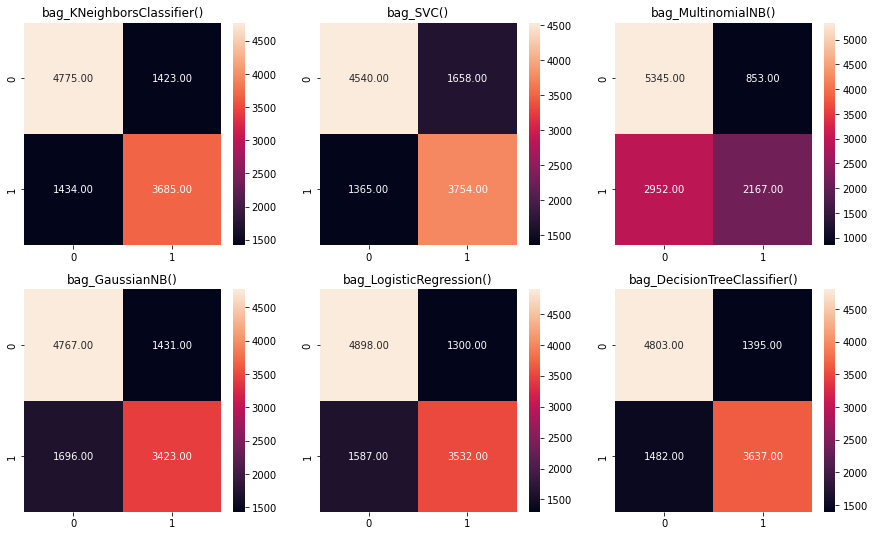

In [331]:
plt.figure(figsize=(15,9))
for i,mod in enumerate(baggedModels): 
    y_pred=mod[1].predict(X_test)
    cm=confusion_matrix(y_test,y_pred)
    plt.subplot(2,3,i+1)
    plt.title(mod[0])
    sns.heatmap(cm,annot=True,fmt=".2f")

now lets do classification report for each bagged model

In [401]:
for 
    y_pred=baggedModels[2][1].predict(X_test)
    print()
    print(classification_report(y_test,y_pred))

ValueError: all arrays must be same length

<hr><hr><hr><hr><hr><hr><hr><hr><hr><hr><hr><hr><hr><hr><hr><hr><hr><hr><hr><hr><hr><hr><hr><hr><hr><hr><hr><hr><hr><hr>
`TODO: see confusion matrix`
<hr><hr><hr><hr><hr><hr><hr><hr><hr><hr><hr><hr><hr><hr><hr><hr><hr><hr><hr><hr><hr><hr><hr><hr><hr><hr><hr><hr><hr><hr>

# part 5 - saving the models

In [139]:
def save_mod(db,dbCollection,client,model_name,model,normalizer):
    database=pymongo.MongoClient(client)
    
    mydb=database[db]
    myCollection=mydb[dbCollection]
    
    pickeled_model=pickle.dumps(model)
    pickeled_normalizer=pickle.dumps(normalizer)

    myCollection.insert_one({
            "model":pickeled_model,
            "name":model_name,
            "scaler":pickeled_normalizer
            })
    # try:
    #     myCollection.insert_one({
    #         "model":pickeled_model,
    #         "name":model_name,
    #         "scaler":pickeled_normalizer
    #         })
    # except:
    #     pickle.dump({
    #     "model":pickeled_model,
    #     "name":model_name,
    #     "scaler":pickeled_normalizer
    #     },open(f"pkl_{model_name}.pkl","wb"))
        # print("model",model_name,"is over 16MB, uploading it with gridfs API")
        # fs=gridfs.GridFS(database.grid_file)
        # fs.put(pickeled_model,filename=model_name)

In [357]:
def save_mod_pickle(dir,modName,model,scaler,x_test,y_test):
    if len(dir)<1:
        raise NameError("must giva a directory")
    
    if not os.path.isdir(dir):
        os.mkdir("./"+dir)

    y_pred=model.predict(x_test)
    precision=recall=f1Score=np.array([[0,1]])

    precision=np.vstack([precision,precision_score(y_test,y_pred,average=None)])
    recall=np.vstack([recall,recall_score(y_test,y_pred,average=None)])
    f1Score=np.vstack([f1Score,f1_score(y_test,y_pred,average=None)])
     
    toPickle={
        "model":model,
        "name":modName,
        "precision":precision,
        "recall":recall,
        "f1-score":f1Score,
        "scaler":scaler
    }
    with open(dir+"/"+modName+".pkl","wb") as f:
            pickle.dump(toPickle,f)

In [346]:
def load_pkl_mod(dir,fileName):
    if len(dir)==0:
        raise NameError("directory name can't be empty")
    
    with open(dir+"/"+fileName,"rb") as f:
            return pickle.load(f)

In [364]:
save_mod_pickle("rawModels",models[0][0],models[0][1],scaler,X_test,y_test)
save_mod_pickle("rawModels",models[1][0],models[1][1],scaler,X_test,y_test)
save_mod_pickle("rawModels",models[2][0],models[2][1],scaler,X_test,y_test)
save_mod_pickle("rawModels",models[3][0],models[3][1],scaler,X_test,y_test)
save_mod_pickle("rawModels",models[4][0],models[4][1],scaler,X_test,y_test)
save_mod_pickle("rawModels",models[5][0],models[5][1],scaler,X_test,y_test)

In [359]:
save_mod_pickle("baggedModels",baggedModels[0][0],baggedModels[0][1],scaler,X_test,y_test)
save_mod_pickle("baggedModels",baggedModels[1][0],baggedModels[1][1],scaler,X_test,y_test)
save_mod_pickle("baggedModels",baggedModels[2][0],baggedModels[2][1],scaler,X_test,y_test)
save_mod_pickle("baggedModels",baggedModels[3][0],baggedModels[3][1],scaler,X_test,y_test)
save_mod_pickle("baggedModels",baggedModels[4][0],baggedModels[4][1],scaler,X_test,y_test)
save_mod_pickle("baggedModels",baggedModels[5][0],baggedModels[5][1],scaler,X_test,y_test)

In [367]:
knnMod=load_pkl_mod("./baggedModels","bag_KNeighborsClassifier().pkl")
svcMod=load_pkl_mod("./baggedModels","bag_SVC().pkl")
mutlNbMod=load_pkl_mod("./baggedModels","bag_MultinomialNB().pkl")
gauNbMod=load_pkl_mod("./baggedModels","bag_GaussianNB().pkl")
logRegMod=load_pkl_mod("./baggedModels","bag_LogisticRegression().pkl")
dectrMod=load_pkl_mod("./baggedModels","bag_DecisionTreeClassifier().pkl")

TODELETE:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

In [ ]:
save_mod(DB,DBCONNECTION,CLIENT,models[0][0],models[0][1],scaler)
save_mod(DB,DBCONNECTION,CLIENT,models[1][0],models[1][1],scaler)
save_mod(DB,DBCONNECTION,CLIENT,models[2][0],models[2][1],scaler)
save_mod(DB,DBCONNECTION,CLIENT,models[3][0],models[3][1],scaler)
save_mod(DB,DBCONNECTION,CLIENT,models[4][0],models[4][1],scaler)


In [332]:
save_mod(DB,"diabetes",CLIENT,baggedModels[0][0],baggedModels[0][1],scaler)
save_mod(DB,"diabetes",CLIENT,baggedModels[1][0],baggedModels[1][1],scaler)
save_mod(DB,"diabetes",CLIENT,baggedModels[2][0],baggedModels[2][1],scaler)
save_mod(DB,"diabetes",CLIENT,baggedModels[3][0],baggedModels[3][1],scaler)
save_mod(DB,"diabetes",CLIENT,baggedModels[4][0],baggedModels[4][1],scaler)

DocumentTooLarge: BSON document too large (290327948 bytes) - the connected server supports BSON document sizes up to 16793598 bytes.